Stack Exchange Data Dump
by Stack Exchange, Inc.

Published September 12, 2016
Usage Attribution-Share Alike 3.0
Topics Stack Exchange Data Dump


#### Stack Exchange is a network of question-and-answer websites on topics in varied fields, each site covering a specific topic, where questions, answers, and users are subject to a reputation award process.

This is an anonymized dump of all user-contributed content on the Stack Exchange network. 

#### Each site is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. 
#### Each site archive includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included readme.txt.

All user content contributed to the Stack Exchange network is cc-by-sa 3.0 licensed, intended to be shared and remixed. We even provide all our data as a convenient data dump.
License: http://creativecommons.org/licenses/by-sa/3.0/
But our cc-by-sa 3.0 licensing, while intentionally permissive, does require attribution:
Attribution — You must attribute the work in the manner specified by the author or licensor (but not in any way that suggests that they endorse you or your use of the work).
Specifically the attribution requirements are as follows:
Visually display or otherwise indicate the source of the content as coming from the Stack Exchange Network. This requirement is satisfied with a discreet text blurb, or some other unobtrusive but clear visual indication.

Ensure that any Internet use of the content includes a hyperlink directly to the original question on the source site on the Network (e.g., http://stackoverflow.com/questions/12345)

Visually display or otherwise clearly indicate the author names for every question and answer used

Ensure that any Internet use of the content includes a hyperlink for each author name directly back to his or her user profile page on the source site on the Network (e.g., http://stackoverflow.com/users/12345/username), directly to the Stack Exchange domain, in standard HTML (i.e. not through a Tinyurl or other such indirect hyperlink, form of obfuscation or redirection), without any “nofollow” command or any other such means of avoiding detection by search engines, and visible even with JavaScript disabled.

For more information, see the Stack Exchange Terms of Service.


Identifier stackexchange
Publicdate 2014-01-21 18:54:32
Mediatype data
Addeddate 2014-01-21 18:54:32
Creator Stack Exchange, Inc.
Date 2016-09-12
Year 2016
Year 2015
Year 2014
Contributor Stack Exchange Community
Licenseurl http://creativecommons.org/licenses/by-sa/3.0/
Backup_location ia905803_10

Archive index: https://archive.org/download/stackexchange

More details on fields: http://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

In [1]:
import xml.etree.ElementTree as ET
#import csv
import itertools
import networkx as net
import matplotlib.pyplot as plot
from __future__ import division
import random
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords

In [2]:
matplotlib inline

In [3]:
#Determine how to extract data
#http://stackoverflow.com/questions/13580246/xml-to-csv-like-format
#http://blog.appliedinformaticsinc.com/how-to-parse-and-convert-xml-to-csv-using-python/
tree = ET.parse('stack-exchange-data-2/Badges.xml')
root = tree.getroot()

In [4]:
#for child in root:
#    print(child.tag,child.attrib)
rows = [child.attrib for child in root]

In [5]:
first_row = rows[0]
badge_head = first_row.keys()
badge_head

['Name', 'Date', 'TagBased', 'UserId', 'Id', 'Class']

In [6]:
print badge_head[0]
print first_row[badge_head[0]]
#rows is a list of dictionary

#print len(badge_head)
#print range(0,len(badge_head))
    

Name
Autobiographer


In [7]:
#set up the text analysis framework using the comments file
tree_comments = ET.parse('stack-exchange-data-2/Comments.xml')
root_comments = tree_comments.getroot()

In [8]:
rows_comments = [child.attrib for child in root_comments]

In [9]:
comments_head = rows_comments[0].keys()
comments_head

['Score', 'Text', 'PostId', 'CreationDate', 'UserId', 'Id']

In [10]:
#Interested in Text and Score
#consider score vs number of words in the comments, 
#words that appear more frequently,
#contains web links?, other?
score_text = []
for row in rows_comments:
    score = int(row['Score'])
    text = row['Text']
    score_text.append([score,text])

In [11]:
#test code
score_text[0:2]

[[2,
  "Good naming convention and well structured code will help you decrease the comments need. Don`t forget that each line of comments you add it's a new line to maintain!!"],
 [17, '+1 for truth, -1 for practicality. :)']]

#### Build the data needed for the network
-People who commented on a post are connected to each other and the poster  
-The strength of the tie is the number of times they appear in the same post  
-Each person will be tagged in a post as a poster or a commenter, so this can be analyzed separately  
-an alternative measure of strength could be the score of their posts or comments

In [12]:
#Bring in the posts data - comments data has already been brought in
tree_posts = ET.parse('stack-exchange-data-2/Posts.xml')
root_posts = tree_posts.getroot()

In [13]:
#get a list of dictionaries with the fields
rows_posts = [child.attrib for child in root_posts]

In [14]:
posts_head = rows_posts[0].keys()
posts_head

['ViewCount',
 'Title',
 'CommunityOwnedDate',
 'LastEditDate',
 'AnswerCount',
 'Score',
 'PostTypeId',
 'OwnerUserId',
 'FavoriteCount',
 'Body',
 'ClosedDate',
 'Tags',
 'LastEditorUserId',
 'LastActivityDate',
 'CommentCount',
 'AcceptedAnswerId',
 'CreationDate',
 'Id']

From comments bring in PostId, UserId, Score, and add a field (Post_Type) that identifies it as a comment.  

From posts bring in Id (as PostId),OwnerUserId (as UserId), Score, and add a field (Post_Type) that identifies it as a post

In [15]:
posters = []

for row in rows_posts:
    
    postid = row['Id']
    #if a user is no longer active, there will be no userId, so the code
    #will skip this post, if there are comments on the post they will still
    #be included as long as those users are still present
    if 'OwnerUserId' in row:
        userid = row['OwnerUserId']
    else:
        continue
    score = int(row['Score'])
    post_type = 'post'
    posters.append([postid,userid,score,post_type])

In [16]:
commenters = []

for row in rows_comments:
    postid = row['PostId']
    if 'UserId' in row:
        userid = row['UserId']
    else:
        continue
    score = int(row['Score'])
    post_type = 'comment'
    commenters.append([postid,userid,score,post_type])

In [17]:
print posters[0:2]
print commenters[0:2]

[['1', '6', 100, 'post'], ['3', '11', 29, 'post']]
[['3', '28', 2, 'comment'], ['20', '9', 17, 'comment']]


For every post create pairs from the poster to each commenter and
between commenters and evey other commentor.  

To simplify just focus on userid to userid, ignore post_type and score for now


???
Create a dictionary of dictionaries
postid: {postid:,userid1:,userid2,score1:,score2:,post_type1:,post_type2}

In [18]:
#test that it has the correct lists.
combined = posters + commenters
n = len(combined)
print combined[0:2]
print combined[n-2:n]

#number of unique postid
print len(set([x[0] for x in combined]))

[['1', '6', 100, 'post'], ['3', '11', 29, 'post']]
[['330073', '3941', 0, 'comment'], ['330073', '61852', 0, 'comment']]
172615


In [19]:
#postid,userid,score,post_type
#get list of unique postid
postid_list = set([x[0] for x in combined])

In [20]:
#for each unique post id, create a dictionary with postid as key 
#with key: value as userids that posted or commented on that post
#http://stackoverflow.com/questions/8550912/python-dictionary-of-dictionaries
#http://stackoverflow.com/questions/3749512/python-group-by

#postid,userid,score,post_type

#get just the postid and userid
post_user = [[x[0],x[1]] for x in combined]
#print post_user[0:4]


from collections import defaultdict

#create default dictionary
d_combo = defaultdict(list)
for k,v in post_user: 
    d_combo[k].append(v)
    
#change format to list of dictionaries with postid as key and list of userid's as value
[{'postid':k, 'userid':v} for k,v in d_combo.items()]


[{'postid': '287144', 'userid': ['5099', '183975', '5099']},
 {'postid': '228054', 'userid': ['118945', '80833', '73447']},
 {'postid': '270119', 'userid': ['13363']},
 {'postid': '228050', 'userid': ['118943']},
 {'postid': '329364', 'userid': ['17320']},
 {'postid': '287145', 'userid': ['109596']},
 {'postid': '44675', 'userid': ['10572', '287', '4623']},
 {'postid': '287149', 'userid': ['20065', '31950', '31950', '20065']},
 {'postid': '99682', 'userid': ['14142']},
 {'postid': '312487', 'userid': ['3819']},
 {'postid': '89370', 'userid': ['20579', '29074', '8810']},
 {'postid': '89371', 'userid': ['1503']},
 {'postid': '89374', 'userid': ['15331', '9293']},
 {'postid': '89375', 'userid': ['1362']},
 {'postid': '319459', 'userid': ['221754']},
 {'postid': '89378', 'userid': ['30155']},
 {'postid': '287140', 'userid': ['83499']},
 {'postid': '246175',
  'userid': ['51654', '8144', '51654', '8144', '51654', '8144', '93183']},
 {'postid': '202448', 'userid': ['22685']},
 {'postid': '25

In [21]:
#for each subdictionary get all combinations, if there are no comments 
#don't include anything, if there are 2 or more add all combinations to pairs.

#try example
#z=[]
#for x in itertools.combinations([1,2,3],2):
#    z.append(list(x))

pairs = []

for k,v in d_combo.iteritems():
    if v == []:
        continue
    setv = set(v)
    if setv == 1:
        continue
    for x in itertools.combinations(setv,2):
        pairs.append(list(x))
    #new = [list(x) for x in itertools.combinations(setv,2)]


In [22]:
#check output
print pairs[0:10]

[['5099', '183975'], ['73447', '118945'], ['73447', '80833'], ['118945', '80833'], ['4623', '287'], ['4623', '10572'], ['287', '10572'], ['20065', '31950'], ['29074', '20579'], ['29074', '8810']]


#### Create a network from the data  
Nodes are users (posters or commenters)  
Edges are if a user is connected to another user because they posted or commented on the same post.  

In [23]:
#Using the pairs of connected nodes build the initial graph

g=net.Graph()

for row in pairs:
    node1 = row[0]
    node2 = row[1]
    g.add_edge(node1,node2)

In [24]:
#write the graph to a file so it doesn't have to be re-created every time
#net.write_pajek(g, "pairs.net")
#g=net.read_pajek("pairs.net")

In [25]:
#Number of nodes in the network
len(g.nodes())

35542

In [26]:
#Number of edges in the network
len(g.edges())

400522

In [27]:
#test an edge
g.edges()[100]

('5983', '24049')

In [28]:
#View the network graph
#net.draw(g)

Degree Centrality: Degree is the number of connections that a node has. In this network it is the number of connections between users in this subset of stack exchange data

In [29]:
#compute the degree of every node in the network
deg = net.degree(g)

In [30]:
#What is the minimum and maximum degree of any node
print min(deg.values())
print max(deg.values())

1
5671


In [31]:
#function to return a sorted degree list 
def sorted_map(map):
    ms = sorted(map.iteritems(), key = lambda(k,v): (-v,k))
    return ms

In [32]:
ds = sorted_map(deg)

In [33]:
#posters with the most connections
ds[0:10]

[('1204', 5671),
 ('31260', 5484),
 ('9113', 3385),
 ('855', 3053),
 ('29020', 2528),
 ('13156', 2235),
 ('22685', 2129),
 ('25936', 2101),
 ('2344', 2063),
 ('935', 2063)]

### These posters all have very high reputation scores in the User file

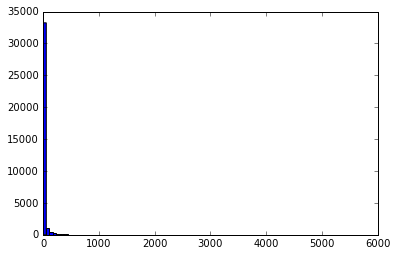

In [96]:
h=plot.hist(deg.values(),100)
#display a histogram of nodes in 100 bins

A histogram of the degree of each user shows that a small number of users have a high number of connections (either comment on a lot of posts, and/or comment on (or post) posts that get a lot of comments which connects them to more posters.

In [97]:
#Eigenvector Centrality
#have to change graph format to use eigenvector function
e = net.Graph(g)

In [98]:
eig = net.eigenvector_centrality(e)

In [99]:
eigs = sorted_map(eig)

In [100]:
eigs[:10]

[('1204', 0.11449655571366553),
 ('31260', 0.11142915642863989),
 ('855', 0.09882176593361156),
 ('29020', 0.09247134355128107),
 ('9113', 0.08822794645380623),
 ('13156', 0.0848379142690249),
 ('935', 0.08444984966990342),
 ('16929', 0.07971190573929984),
 ('2344', 0.07970697915459081),
 ('934', 0.07940013431898067)]

### This list is nearly identical to the degree centrality list. These posters all have very high reputation scores in the User file

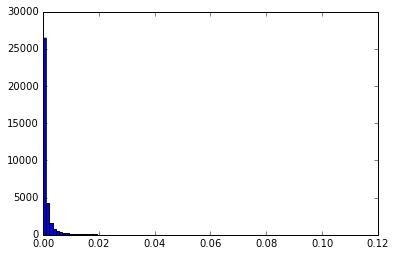

In [101]:
h=plot.hist(eig.values(),100)

### Text Analysis

In [102]:
score_text[0]

[2,
 "Good naming convention and well structured code will help you decrease the comments need. Don`t forget that each line of comments you add it's a new line to maintain!!"]

In [103]:
#split the data into high score and low score to create a binary classification problem
#get some stats on the score
#the text length will need to be binned as well
scores = [x[0] for x in score_text]
text_len = [len(x[1]) for x in score_text]

In [104]:
min_score = min(scores)
max_score = max(scores)
avg_score = sum(scores)/len(scores)
#histogram of scores
print min_score
print max_score
print avg_score

0
300
1.31102013094


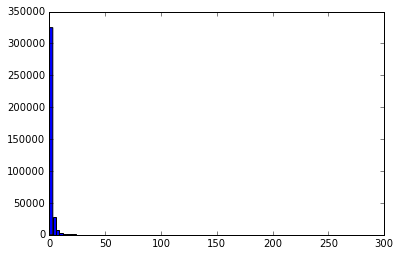

In [105]:
score_hist=plot.hist(scores,100)

In [172]:
#what percent of scores are higher than 3
score_split = 5
round(len([x for x in scores if x>score_split])/len(scores),2)

0.05

In [173]:
#If we define high scores as greater than 5 then 5% of scores are high scores
#revise the list to have score category (1 for higher, 0 otherwise)
scores1 = [[1,x[1]] for x in score_text if x[0] > score_split]
scores2 = [[0,x[1]] for x in score_text if x[0] <= score_split]
dataset = scores1 + scores2


In [174]:
#print dataset[0:10]
#random.shuffle(dataset)
#print dataset[0:10]

In [175]:
print len(scores1)
print len(scores2)

18419
352602


In [176]:
#The text length (number of words) will need to be binned, check stats on the text length
min_len = min(text_len)
max_len = max(text_len)
avg_len = sum(text_len)/len(text_len)
#histogram of scores
print min_len
print max_len
print avg_len


6
600
214.805164667


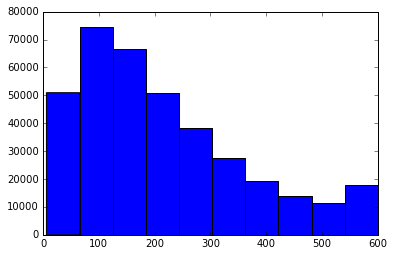

In [177]:
#divide into 10 bins
score_hist=plot.hist(text_len,10)

In [178]:
#the 10 bins look reasonable, bins of size 60
(nS, bins, patches)=score_hist
##NEED TO automatically bin the data
bins_adj =  list(bins[1:len(bins)])
bins_adj = [int(round(x,0)) for x in bins_adj]
#print type(bins_adj)
print bins_adj

#get data into these bins
bin_len = []

#print dataset[0][0]

#print bin_len + [2]
#print min(bins_adj)

#print min([y for y in bins_adj if y >= 100])

for x in text_len:
    bin_x = min([y for y in bins_adj if y >= x])
    #print bin_x
    bin_len.append(bin_x)
#print bin_len


[65, 125, 184, 244, 303, 362, 422, 481, 541, 600]


In [188]:
#combine bin_len which has the bin for each item, with the first element of dataset which has the binary score.

dataset2 = [[dataset[i][0],bin_len[i]] for i in bin_len]

print dataset2[0]

[0, 125]


In [235]:
#break the dataset into test set, dev set and train set
#randomize the dataset
random.shuffle(dataset2)
print(dataset2[0])
test_set, dev_set, train_set = dataset2[0:37000], dataset2[37000:74000], dataset2[74000:]
#combine dev and train for later reshuffle
train_dev_set = train_set + dev_set
#check set sizes
len(dataset2), len(test_set), len(dev_set), len(train_set), len(train_dev_set)

[0, 184]


(371021, 37000, 37000, 297021, 334021)

In [236]:
#first classifier, length of the text, maybe longer posts have higher scores
def spam_features(line):
    return {'length of text bin': line[1]}

In [237]:
#test function
spam_features(dataset2[0])

{'length of text bin': 184}

In [238]:
#pair the features with the spam flag
featureset_train = [(spam_features(line), line[0]) for line in train_set]
featureset_dev = [(spam_features(line), line[0]) for line in dev_set]
featureset_test = [(spam_features(line), line[0]) for line in test_set]

In [239]:
#test what's in featuresets
featureset_train[0],featureset_dev[2] 

(({'length of text bin': 125}, 1), ({'length of text bin': 184}, 0))

In [240]:
classifier = nltk.NaiveBayesClassifier.train(featureset_train)

In [241]:
print nltk.classify.accuracy(classifier, featureset_dev)

0.900216216216


In [242]:
#check the accuracy on the test set
print nltk.classify.accuracy(classifier, featureset_test)

0.899810810811


In [244]:
classifier.show_most_informative_features(5)

Most Informative Features
      length of text bin = 125                 1 : 0      =      2.3 : 1.0


### Text that is in the 125 bin (between 65 and 125 words) is 2.3 times more likely to have a high score (greater than 5). 

In [253]:
#Explore most common words: get all words in the comments, split by high score vs low score and compare
score_text[0][1]

#tokenize the text of the comments
tokens_high = [nltk.word_tokenize(x[1]) for x in score_text if x[0] == 1]
tokens_low = [nltk.word_tokenize(x[1]) for x in score_text if x[0] == 0]

print tokens_high[0]
print tokens_low[0]

['@', 'Lorenzo', ':', 'sorry', ',', 'I', "'ve", 'read', 'it', 'and', 'did', 'not', 'catch', 'this', 'one', '...']
['@', 'Gabriel', ':', 'that', 'was', 'already', 'in', 'my', 'answer', ',', 'look', 'at', 'the', 'end', '.']


### The remainder of this code ran on the smaller data set but the processing time is very long on the larger dataset and I was not able to run it.

In [256]:
'''
#split into words
words_high = []
words_low = []
for row in tokens_high:
    add_words = [w.lower() for w in row]
    words_high = words_high + add_words
'''

'\n#split into words\nwords_high = []\nwords_low = []\nfor row in tokens_high:\n    add_words = [w.lower() for w in row]\n    words_high = words_high + add_words\n'

In [ ]:
'''
for row in tokens_low:
    add_words = [w.lower() for w in row]
    words_low = words_low + add_words

print words_high[0]
print words_low[0]
'''

In [ ]:
'''
#remove stop words
#get English stop words like - high frequency words like 'the','to','her' 
stops = stopwords.words('english')
'''

In [ ]:
'''
#remove stops words and single character words (removes punctuation etc.)
words2_high = [x for x in words_high if x not in stops and len(x) > 3]
words2_low = [x for x in words_low if x not in stops and len(x) > 3]
'''

In [ ]:
'''
#get the frequency distribution of the words in the comments
fdist_high = FreqDist(words2_high)
fdist_low = FreqDist(words2_low)
'''


In [ ]:
'''
#limit the features, get a list of the most common 2000 words and their frequency
words_high_2000 = fdist_high.most_common(2000)
words_low_2000 = fdist_low.most_common(2000)
'''

In [ ]:
'''
words_high_2000[0:10]
'''

In [ ]:
'''
words_low_2000[0:10]
'''

'''
There is no real difference in the top 10 most common words, even once stop words are eliminated from the list
'''